(sec-dataset-advanced-examples)=
# Quantify dataset - advanced examples

```{seealso}
The complete source code of this tutorial can be found in

{nb-download}`Quantify dataset - advanced examples.ipynb`
```

Here we will explore a few advanced usages of the Quantify dataset and how it can
accommodate them.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from rich import pretty

from quantify_core.analysis.calibration import rotate_to_calibrated_axis
from quantify_core.analysis.fitting_models import exp_decay_func
from quantify_core.data import handling as dh
from quantify_core.utilities import dataset_examples
from quantify_core.utilities.dataset_examples import (
    mk_nested_mc_dataset,
    mk_shots_from_probabilities,
    mk_surface7_cyles_dataset,
)
from quantify_core.utilities.examples_support import (
    mk_iq_shots,
    round_trip_dataset,
)
from quantify_core.utilities.inspect_utils import display_source_code

pretty.install()

dh.set_datadir(Path.home() / "quantify-data")  # change me!

## Dataset for an "unstructured" experiment

Let's take consider a Surface Code experiment, in particular the one portrayed in
Fig. 4b from one of the papers from DiCarlo Lab {cite}`marques_logical_qubit_2021`.

For simplicity, we will not use exactly the same schedule, because what matters here
are the measurements. It is difficult to deal with the results of these measurements
because we have a few repeating cycles followed by a final measurement that leaves the
overall dataset "unstructured".

```{figure} /images/surface-7-sched.png
:width: 100%
```

``````{admonition} Source code for generating this schedule and visualizing it
:class: dropdown, info

If you want to create and visualize the schedule above using `quantify-scheduler`,
you can use this code:

```{code-block} python
from quantify_scheduler import Schedule
from quantify_scheduler.operations.gate_library import CZ, Y90, Measure, Reset, X
from quantify_scheduler.visualization.circuit_diagram import circuit_diagram_matplotlib

def mk_surface7_sched(num_cycles: int = 3):
    """Generates a schedule with some of the feature of a Surface 7 experiment as
    portrayed in Fig. 4b of :cite:`marques_logical_qubit_2021`.

    Parameters
    ----------
    num_cycles
        The number of times to repeat the main cycle.

    Returns
    -------
    :
        A schedule similar to a Surface 7 dance.
    """

    sched = Schedule("S7 dance")

    q_d1, q_d2, q_d3, q_d4 = [f"D{i}" for i in range(1, 5)]
    q_a1, q_a2, q_a3 = [f"A{i}" for i in range(1, 4)]
    all_qubits = q_d1, q_d2, q_d3, q_d4, q_a1, q_a2, q_a3

    sched.add(Reset(*all_qubits))

    for cycle in range(num_cycles):
        sched.add(Y90(q_d1))
        for qubit in [q_d2, q_d3, q_d4]:
            sched.add(Y90(qubit), ref_pt="start", rel_time=0)
        sched.add(Y90(q_a2), ref_pt="start", rel_time=0)

        for qubit in [q_d2, q_d1, q_d4, q_d3]:
            sched.add(CZ(qC=qubit, qT=q_a2))

        sched.add(Y90(q_d1))
        for qubit in [q_d2, q_d3, q_d4]:
            sched.add(Y90(qubit), ref_pt="start", rel_time=0)
        sched.add(Y90(q_a2), ref_pt="start", rel_time=0)

        sched.add(Y90(q_a1), ref_pt="end", rel_time=0)
        sched.add(Y90(q_a3), ref_pt="start", rel_time=0)

        sched.add(CZ(qC=q_d1, qT=q_a1))
        sched.add(CZ(qC=q_d2, qT=q_a3))
        sched.add(CZ(qC=q_d3, qT=q_a1))
        sched.add(CZ(qC=q_d4, qT=q_a3))

        sched.add(Y90(q_a1), ref_pt="end", rel_time=0)
        sched.add(Y90(q_a3), ref_pt="start", rel_time=0)

        sched.add(Measure(q_a2, acq_index=cycle))
        for qubit in (q_a1, q_a3):
            sched.add(Measure(qubit, acq_index=cycle), ref_pt="start", rel_time=0)

        for qubit in [q_d1, q_d2, q_d3, q_d4]:
            sched.add(X(qubit), ref_pt="start", rel_time=0)

    # final measurements

    sched.add(Measure(*all_qubits[:4], acq_index=0), ref_pt="end", rel_time=0)

    return sched

sched = mk_surface7_sched(num_cycles=3)
f, ax = circuit_diagram_matplotlib(sched)
f.set_figwidth(30)
```
``````

How do we store all the shots for this measurement?
We might want this because, e.g., we know we have an issue with leakage to the second
excited state of a transmon and we would like to be able to store and inspect raw data.

To support such use-cases we will have a dimension in the dataset for the repeating cycles
and one extra dimension for the final measurement.

In [2]:
# mock data parameters
num_shots = 128  # NB usually >~1000 in real experiments
ground = -0.2 + 0.65j
excited = 0.7 + 4j
centroids = ground, excited
sigmas = [0.1] * 2

display_source_code(mk_iq_shots)
display_source_code(mk_shots_from_probabilities)
display_source_code(mk_surface7_cyles_dataset)

def mk_iq_shots(
    num_shots: int = 128,
    sigmas: Union[Tuple[float], NDArray[np.float64]] = (0.1, 0.1),
    centers: Union[Tuple[complex], NDArray[np.complex128]] = (-0.2 + 0.65j, 0.7 + 4j),
    probabilities: Union[Tuple[float], NDArray[np.float64]] = (0.4, 0.6),
    seed: Union[int, None] = 112233,
) -> NDArray:
    """
    Generate clusters of (I + 1j*Q) points with a Gaussian distribution.

    Utility to mock the data coming from qubit readout experiments.
    Clusters are centered around ``centers`` and data points are distributed between
    them according to ``probabilities``.

    .. seealso:: :ref:`howto-utilities-examples-ssro`

    Parameters
    ----------
    num_shots
        The number of shot to generate.
    sigma
        The sigma of the Gaussian distribution used for both real and imaginary parts.
    centers
        The center of each cluster on the imaginary plane.
    probabilities
        The probabilities of each cluster being randomly selected for each shot.
    seed
        Random number generator seed passed to ``numpy.random.default_rng``.
    """
    if not len(sigmas) == len(centers) == len(probabilities):
        raise ValueError(
            f"Incorrect input. sigmas={sigmas}, centers={centers} and "
            f"probabilities={probabilities} must have the same length."
        )

    rng = np.random.default_rng(seed=seed)

    cluster_indices = tuple(range(len(centers)))
    choices = rng.choice(a=cluster_indices, size=num_shots, p=probabilities)

    shots = []
    for idx in cluster_indices:
        num_shots_this_cluster = np.sum(choices == idx)
        i_data = rng.normal(
            loc=centers[idx].real,
            scale=sigmas[idx],
            size=num_shots_this_cluster,
        )
        q_data = rng.normal(
            loc=centers[idx].imag,
            scale=sigmas[idx],
            size=num_shots_this_cluster,
        )
        shots.append(i_data + 1j * q_data)
    return np.concatenate(shots)

def mk_shots_from_probabilities(probabilities: Union[np.ndarray, list], **kwargs):
    """Generates multiple shots for a list of probabilities assuming two states.

    Parameters
    ----------
    probabilities
        The list/array of the probabilities of one of the states.
    **kwargs
        Keyword arguments passed to
        :func:`~quantify_core.utilities.examples_support.mk_iq_shots`.

    Returns
    -------
    :
        Array containing the shots. Shape: (num_shots, len(probabilities)).
    """

    shots = np.array(
        tuple(
            mk_iq_shots(probabilities=[prob, 1 - prob], **kwargs)
            for prob in probabilities
        )
    ).T

    return shots

def mk_surface7_cyles_dataset(num_cycles: int = 3, **kwargs) -> xr.Dataset:
    """
    See also :func:`mk_surface7_sched` inlined in the documentation as an example in:
        :ref:`sec-dataset-advanced-examples`



    Parameters
    ----------
    num_cycles
        The number of repeating cycles before the final measurement.
    **kwargs
        Keyword arguments passed to :func:`~.mk_shots_from_probabilities`.
    """

    cycles = range(num_cycles)

    mock_data = mk_shots_from_probabilities(
        probabilities=[np.random.random() for _ in cycles], **kwargs
    )

    mock_data_final = mk_shots_from_probabilities(
        probabilities=[np.random.random()], **kwargs
    )

    # %%
    data_vars = {}

    # NB same random data is used for all qubits only for the simplicity of the mock!
    for qubit in (f"A{i}" for i in range(3)):
        data_vars[f"{qubit}_shots"] = (
            ("repetitions", "dim_cycle"),
            mock_data,
            mk_main_var_attrs(
                unit="V", long_name=f"IQ amplitude {qubit}", has_repetitions=True
            ),
        )

    for qubit in (f"D{i}" for i in range(4)):
        data_vars[f"{qubit}_shots"] = (
            ("repetitions", "dim_final"),
            mock_data_final,
            mk_main_var_attrs(
                unit="V", long_name=f"IQ amplitude {qubit}", has_repetitions=True
            ),
        )

    cycle_attrs = mk_main_coord_attrs(long_name="Surface code cycle number")
    final_msmt_attrs = mk_main_coord_attrs(long_name="Final measurement")
    coords = dict(
        cycle=("dim_cycle", cycles, cycle_attrs),
        final_msmt=("dim_final", [0], final_msmt_attrs),
    )

    dataset = xr.Dataset(
        data_vars=data_vars,
        coords=coords,
        attrs=mk_dataset_attrs(),
    )

    return dataset

In [3]:
dataset = mk_surface7_cyles_dataset(
    num_shots=num_shots, sigmas=sigmas, centers=centroids
)

assert dataset == round_trip_dataset(dataset)  # confirm read/write

dataset

<xarray.Dataset> Size: 27kB
Dimensions:     (repetitions: 128, dim_cycle: 3, dim_final: 1)
Coordinates:
    cycle       (dim_cycle) int64 24B 0 1 2
    final_msmt  (dim_final) int64 8B 0
Dimensions without coordinates: repetitions, dim_cycle, dim_final
Data variables:
    A0_shots    (repetitions, dim_cycle) complex128 6kB (-0.23630343679164473...
    A1_shots    (repetitions, dim_cycle) complex128 6kB (-0.23630343679164473...
    A2_shots    (repetitions, dim_cycle) complex128 6kB (-0.23630343679164473...
    D0_shots    (repetitions, dim_final) complex128 2kB (-0.23630343679164473...
    D1_shots    (repetitions, dim_final) complex128 2kB (-0.23630343679164473...
    D2_shots    (repetitions, dim_final) complex128 2kB (-0.23630343679164473...
    D3_shots    (repetitions, dim_final) complex128 2kB (-0.23630343679164473...
Attributes:
    tuid:                      20241106-152908-767-d0fe11
    dataset_name:              
    dataset_state:             None
    timestamp_start:           None
    timestamp_end:             None
    quantify_dataset_version:  2.0.0
    software_versions:         {}
    relationships:             []
    json_serialize_exclude:    []

In [4]:
dataset.A1_shots.shape, dataset.D1_shots.shape

((128, 3), (128, 1))

In [5]:
dataset_gridded = dh.to_gridded_dataset(
    dataset, dimension="dim_cycle", coords_names=["cycle"]
)
dataset_gridded = dh.to_gridded_dataset(
    dataset_gridded, dimension="dim_final", coords_names=["final_msmt"]
)
dataset_gridded

<xarray.Dataset> Size: 27kB
Dimensions:     (repetitions: 128, cycle: 3, final_msmt: 1)
Coordinates:
  * cycle       (cycle) int64 24B 0 1 2
  * final_msmt  (final_msmt) int64 8B 0
Dimensions without coordinates: repetitions
Data variables:
    A0_shots    (repetitions, cycle) complex128 6kB (-0.23630343679164473+0.7...
    A1_shots    (repetitions, cycle) complex128 6kB (-0.23630343679164473+0.7...
    A2_shots    (repetitions, cycle) complex128 6kB (-0.23630343679164473+0.7...
    D0_shots    (repetitions, final_msmt) complex128 2kB (-0.2363034367916447...
    D1_shots    (repetitions, final_msmt) complex128 2kB (-0.2363034367916447...
    D2_shots    (repetitions, final_msmt) complex128 2kB (-0.2363034367916447...
    D3_shots    (repetitions, final_msmt) complex128 2kB (-0.2363034367916447...
Attributes:
    tuid:                      20241106-152908-767-d0fe11
    dataset_name:              
    dataset_state:             None
    timestamp_start:           None
    timestamp_end:             None
    quantify_dataset_version:  2.0.0
    software_versions:         {}
    relationships:             []
    json_serialize_exclude:    []

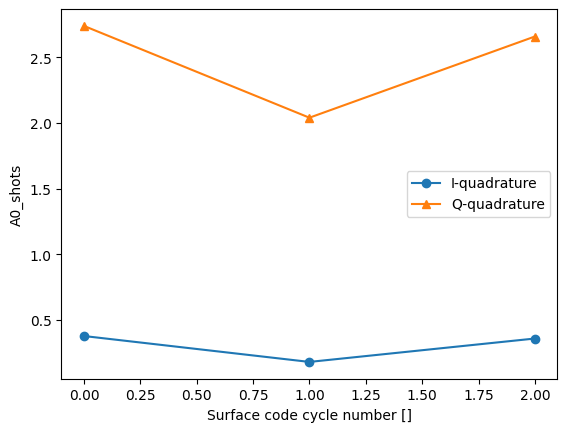

In [6]:
dataset_gridded.A0_shots.real.mean("repetitions").plot(marker="o", label="I-quadrature")
dataset_gridded.A0_shots.imag.mean("repetitions").plot(marker="^", label="Q-quadrature")
_ = plt.gca().legend()

(sec-nested-mc-example)=
## Dataset for a "nested MeasurementControl" experiment

Now consider a dataset that has been constructed by an experiment involving the
operation of two
{class}`.MeasurementControl` objects. The second of
them performs a "meta" outer loop in which we sweep a flux bias and then perform
several experiments to characterize a transmon qubit, e.g. determining the frequency of
a read-out resonator, the frequency of the transmon, and its T1 lifetime.

Below we showcase what the data from the dataset containing the T1 experiment results
could look like

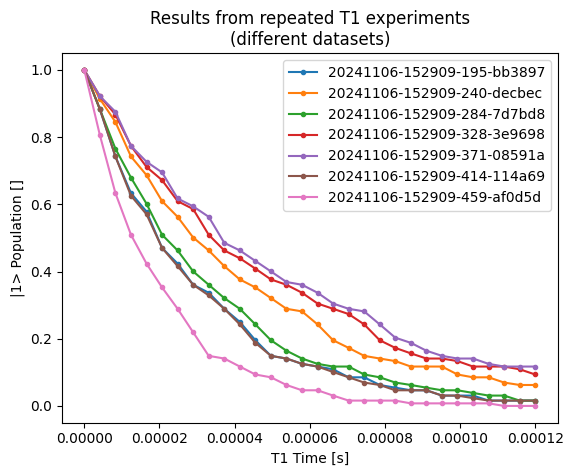

In [7]:
fig, ax = plt.subplots()
rng = np.random.default_rng(seed=112244)  # random number generator

num_t1_datasets = 7
t1_times = np.linspace(0, 120e-6, 30)

for tau in rng.uniform(10e-6, 50e-6, num_t1_datasets):
    probabilities = exp_decay_func(
        t=t1_times, tau=tau, offset=0, n_factor=1, amplitude=1
    )
    dataset = dataset_examples.mk_t1_av_with_cal_dataset(t1_times, probabilities)

    round_trip_dataset(dataset)  # confirm read/write
    dataset_g = dh.to_gridded_dataset(
        dataset, dimension="main_dim", coords_names=["t1_time"]
    )
    # rotate the iq data
    rotated_and_normalized = rotate_to_calibrated_axis(
        dataset_g.q0_iq_av.values, *dataset_g.q0_iq_av_cal.values
    )
    rotated_and_normalized_da = xr.DataArray(dataset_g.q0_iq_av)
    rotated_and_normalized_da.values = rotated_and_normalized
    rotated_and_normalized_da.attrs["long_name"] = "|1> Population"
    rotated_and_normalized_da.attrs["units"] = ""
    rotated_and_normalized_da.real.plot(ax=ax, label=dataset.tuid, marker=".")
ax.set_title("Results from repeated T1 experiments\n(different datasets)")
_ = ax.legend()

Since the raw data is now split among several datasets, we would like to keep a
reference to all these datasets in our "combined" datasets. Below we showcase how this
can be achieved, along with some useful xarray features and known limitations.

We start by generating a mock dataset that combines all the information that would have
been obtained from analyzing a series of other datasets.

In [8]:
display_source_code(mk_nested_mc_dataset)

def mk_nested_mc_dataset(
    num_points: int = 12,
    flux_bias_min_max: tuple = (-0.04, 0.04),
    resonator_freqs_min_max: tuple = (7e9, 7.3e9),
    qubit_freqs_min_max: tuple = (4.5e9, 5.0e9),
    t1_values_min_max: tuple = (20e-6, 50e-6),
    seed: Optional[int] = 112233,
) -> xr.Dataset:
    """
    Generates a dataset with dataset references and several coordinates that serve to
    index the same variables.

    Note that the each value for ``resonator_freqs``, ``qubit_freqs`` and ``t1_values``
    would have been extracted from other dataset corresponding to individual experiments
    with their own dataset.

    Parameters
    ----------
    num_points
        Number of datapoints to generate (used for all variables/coordinates).
    flux_bias_min_max
        Range for mock values.
    resonator_freqs_min_max
        Range for mock values.
    qubit_freqs_min_max
        Range for mock values.
    t1_values_min_max
        Range for mock random values.
    seed
        Random number generator seed passed to ``numpy.random.default_rng``.
    """
    rng = np.random.default_rng(seed=seed)  # random number generator

    flux_bias_vals = np.linspace(*flux_bias_min_max, num_points)
    resonator_freqs = np.linspace(*resonator_freqs_min_max, num_points)
    qubit_freqs = np.linspace(*qubit_freqs_min_max, num_points)
    t1_values = rng.uniform(*t1_values_min_max, num_points)

    resonator_freq_tuids = [dh.gen_tuid() for _ in range(num_points)]
    qubit_freq_tuids = [dh.gen_tuid() for _ in range(num_points)]
    t1_tuids = [dh.gen_tuid() for _ in range(num_points)]

    coords = dict(
        flux_bias=(
            "main_dim",
            flux_bias_vals,
            mk_main_coord_attrs(long_name="Flux bias", unit="A"),
        ),
        resonator_freq_tuids=(
            "main_dim",
            resonator_freq_tuids,
            mk_main_coord_attrs(
                long_name="Dataset TUID resonator frequency", is_dataset_ref=True
            ),
        ),
        qubit_freq_tuids=(
            "main_dim",
            qubit_freq_tuids,
            mk_main_coord_attrs(
                long_name="Dataset TUID qubit frequency", is_dataset_ref=True
            ),
        ),
        t1_tuids=(
            "main_dim",
            t1_tuids,
            mk_main_coord_attrs(long_name="Dataset TUID T1", is_dataset_ref=True),
        ),
    )

    data_vars = dict(
        resonator_freq=(
            "main_dim",
            resonator_freqs,
            mk_main_var_attrs(long_name="Resonator frequency", unit="Hz"),
        ),
        qubit_freq=(
            "main_dim",
            qubit_freqs,
            mk_main_var_attrs(long_name="Qubit frequency", unit="Hz"),
        ),
        t1=(
            "main_dim",
            t1_values,
            mk_main_var_attrs(long_name="T1", unit="s"),
        ),
    )
    dataset_attrs = mk_dataset_attrs()

    dataset = xr.Dataset(data_vars=data_vars, coords=coords, attrs=dataset_attrs)

    return dataset

In [9]:
dataset = mk_nested_mc_dataset(num_points=num_t1_datasets)
assert dataset == round_trip_dataset(dataset)  # confirm read/write
dataset

<xarray.Dataset> Size: 2kB
Dimensions:               (main_dim: 7)
Coordinates:
    flux_bias             (main_dim) float64 56B -0.04 -0.02667 ... 0.02667 0.04
    resonator_freq_tuids  (main_dim) <U26 728B '20241106-152909-730-61c7ff' ....
    qubit_freq_tuids      (main_dim) <U26 728B '20241106-152909-731-74847a' ....
    t1_tuids              (main_dim) <U26 728B '20241106-152909-731-4d1be5' ....
Dimensions without coordinates: main_dim
Data variables:
    resonator_freq        (main_dim) float64 56B 7e+09 7.05e+09 ... 7.3e+09
    qubit_freq            (main_dim) float64 56B 4.5e+09 4.583e+09 ... 5e+09
    t1                    (main_dim) float64 56B 4.238e-05 ... 4.154e-05
Attributes:
    tuid:                      20241106-152909-732-ccc0ae
    dataset_name:              
    dataset_state:             None
    timestamp_start:           None
    timestamp_end:             None
    quantify_dataset_version:  2.0.0
    software_versions:         {}
    relationships:             []
    json_serialize_exclude:    []

In this case the four main coordinates are not orthogonal coordinates, but instead
just different labels for the same data points, also known as a "multi-index".

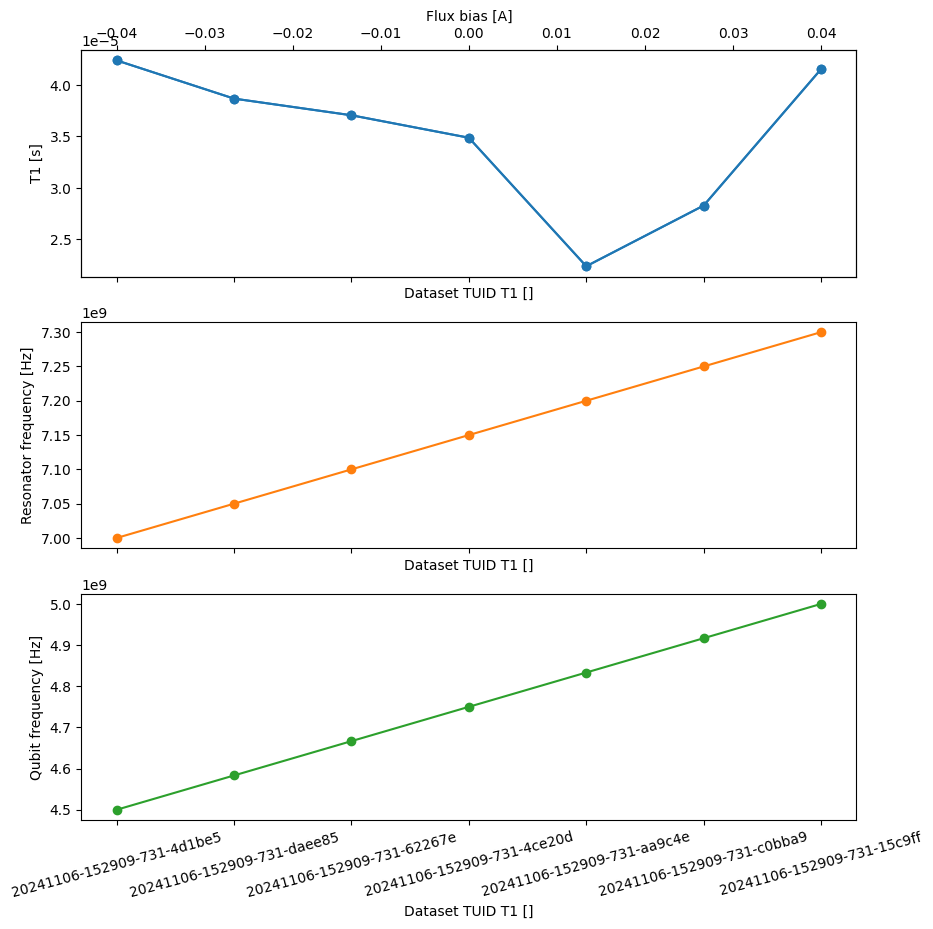

In [10]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

_ = dataset.t1.plot(x="flux_bias", marker="o", ax=axs[0].twiny(), color="C0")
x = "t1_tuids"
_ = dataset.t1.plot(x=x, marker="o", ax=axs[0], color="C0")
_ = dataset.resonator_freq.plot(x=x, marker="o", ax=axs[1], color="C1")
_ = dataset.qubit_freq.plot(x=x, marker="o", ax=axs[2], color="C2")
for tick in axs[2].get_xticklabels():
    tick.set_rotation(15)  # avoid tuid labels overlapping

It is possible to work with an explicit MultiIndex within a (python) xarray object:

In [11]:
dataset_multi_indexed = dataset.set_index({"main_dim": tuple(dataset.t1.coords.keys())})
dataset_multi_indexed

<xarray.Dataset> Size: 2kB
Dimensions:               (main_dim: 7)
Coordinates:
  * main_dim              (main_dim) object 56B MultiIndex
  * flux_bias             (main_dim) float64 56B -0.04 -0.02667 ... 0.02667 0.04
  * resonator_freq_tuids  (main_dim) <U26 728B '20241106-152909-730-61c7ff' ....
  * qubit_freq_tuids      (main_dim) <U26 728B '20241106-152909-731-74847a' ....
  * t1_tuids              (main_dim) <U26 728B '20241106-152909-731-4d1be5' ....
Data variables:
    resonator_freq        (main_dim) float64 56B 7e+09 7.05e+09 ... 7.3e+09
    qubit_freq            (main_dim) float64 56B 4.5e+09 4.583e+09 ... 5e+09
    t1                    (main_dim) float64 56B 4.238e-05 ... 4.154e-05
Attributes:
    tuid:                      20241106-152909-732-ccc0ae
    dataset_name:              
    dataset_state:             None
    timestamp_start:           None
    timestamp_end:             None
    quantify_dataset_version:  2.0.0
    software_versions:         {}
    relationships:             []
    json_serialize_exclude:    []

The MultiIndex is very handy for selecting data in different ways, e.g.:

In [12]:
index = 2
dataset_multi_indexed.qubit_freq.sel(
    qubit_freq_tuids=dataset_multi_indexed.qubit_freq_tuids.values[index]
)

<xarray.DataArray 'qubit_freq' (main_dim: 1)> Size: 8B
array([4.66666667e+09])
Coordinates:
  * main_dim              (main_dim) object 8B MultiIndex
  * flux_bias             (main_dim) float64 8B -0.01333
  * resonator_freq_tuids  (main_dim) <U26 104B '20241106-152909-730-757ca8'
  * t1_tuids              (main_dim) <U26 104B '20241106-152909-731-62267e'
    qubit_freq_tuids      <U26 104B '20241106-152909-731-710cb0'
Attributes:
    unit:                    Hz
    long_name:               Qubit frequency
    is_main_var:             True
    uniformly_spaced:        True
    grid:                    True
    is_dataset_ref:          False
    has_repetitions:         False
    json_serialize_exclude:  []

In [13]:
dataset_multi_indexed.qubit_freq.sel(t1_tuids=dataset.t1_tuids.values[index])

<xarray.DataArray 'qubit_freq' (main_dim: 1)> Size: 8B
array([4.66666667e+09])
Coordinates:
  * main_dim              (main_dim) object 8B MultiIndex
  * flux_bias             (main_dim) float64 8B -0.01333
  * resonator_freq_tuids  (main_dim) <U26 104B '20241106-152909-730-757ca8'
  * qubit_freq_tuids      (main_dim) <U26 104B '20241106-152909-731-710cb0'
    t1_tuids              <U26 104B '20241106-152909-731-62267e'
Attributes:
    unit:                    Hz
    long_name:               Qubit frequency
    is_main_var:             True
    uniformly_spaced:        True
    grid:                    True
    is_dataset_ref:          False
    has_repetitions:         False
    json_serialize_exclude:  []

### Known limitations

Unfortunately, at the moment the MultiIndex has the problem of not being compatible with
the NetCDF format used to write to disk:

In [14]:
try:
    assert dataset_multi_indexed == round_trip_dataset(dataset_multi_indexed)
except NotImplementedError as exp:
    print(exp)

variable 'main_dim' is a MultiIndex, which cannot yet be serialized. Instead, either use reset_index() to convert MultiIndex levels into coordinate variables instead or use https://cf-xarray.readthedocs.io/en/latest/coding.html.


We could make our load/write utilities take care of setting and resetting the index
under the hood. Though there are some nuances there as well. If we would do that then
some extra metadata needs to be stored in order to store/restore the multi-index.
At the moment, the MultiIndex is not supported when writing a Quantify dataset to
disk. Below we show a few complications related to this.

Fortunately, the MultiIndex can be reset back:

In [15]:
dataset_multi_indexed.reset_index(dims_or_levels="main_dim")

<xarray.Dataset> Size: 2kB
Dimensions:               (main_dim: 7)
Coordinates:
    flux_bias             (main_dim) float64 56B -0.04 -0.02667 ... 0.02667 0.04
    resonator_freq_tuids  (main_dim) <U26 728B '20241106-152909-730-61c7ff' ....
    qubit_freq_tuids      (main_dim) <U26 728B '20241106-152909-731-74847a' ....
    t1_tuids              (main_dim) <U26 728B '20241106-152909-731-4d1be5' ....
Dimensions without coordinates: main_dim
Data variables:
    resonator_freq        (main_dim) float64 56B 7e+09 7.05e+09 ... 7.3e+09
    qubit_freq            (main_dim) float64 56B 4.5e+09 4.583e+09 ... 5e+09
    t1                    (main_dim) float64 56B 4.238e-05 ... 4.154e-05
Attributes:
    tuid:                      20241106-152909-732-ccc0ae
    dataset_name:              
    dataset_state:             None
    timestamp_start:           None
    timestamp_end:             None
    quantify_dataset_version:  2.0.0
    software_versions:         {}
    relationships:             []
    json_serialize_exclude:    []

In [16]:
all(dataset_multi_indexed.reset_index("main_dim").t1_tuids == dataset.t1_tuids)

True

But, for example, the `dtype` has been changed to `object`
(from fixed-length string):

In [17]:
dataset.t1_tuids.dtype, dataset_multi_indexed.reset_index("main_dim").t1_tuids.dtype

(dtype('<U26'), dtype('<U26'))

In [18]:
dataset.t1_tuids.dtype == dataset_multi_indexed.reset_index("main_dim").t1_tuids.dtype

True